<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/operanalyst/shosim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teorie hromadné obsluhy

## Teorie

### Otázky k vyřešení

- Jak dlouhá bude fronta?
- Jak dlouho se ve frontě čeká?
- Jaká je pravděpodobnost, že obsluha je volná / nepracuje?

### Rozdělení

- Systémy s čekáním. Požadavek, zákazník, letoun, apod. se zařadí do fronty a čeká na obsluhu.
- Systémy s odmítnutím. Požadavek otestuje dostupnost obsluhy a jestliže není obsloužen, systém opouští (letoun).

- Systémy s odchodem. Po určité době požadavek systém opouští, aniž by byl obsloužen.

## Krátké připomenutí
Kandalova notace

Systémy M/M/1, M/M/n

Pro systém M/M/1 platí rovnice o průměrné délce fronty

$$L = \frac{\lambda}{\mu}$$

kde L je  průměrná délka fronty

$\lambda$ je intenzita toku požadavků

$\mu$ je intenzita obsluhy

odkaz https://en.wikipedia.org/wiki/Queueing_theory

## Simulace toku požadavků

### Poisonův tok

Poisonův tok je model např. příchodu zákazníků k přepážce, kde jsou obsluhováni. Pro modelování potřebujeme generovat posloupnost příchodů. Interval mezi jednotlivými příchody lze generovat podle následujícího vztahu

$$r'=-\frac{1}{\lambda}ln(r)$$

kde $r$ je náhodné číslo s rovnoměrným rozložením a $r'$ je náhodný interval mezi dvěma příchody.

Stejným vztahem lze vypočítat náhodnou délku obsluhy (pro systémy M/M/1 nebo M/M/n)

https://preshing.com/20111007/how-to-generate-random-timings-for-a-poisson-process/

In [14]:
import numpy as np
from numpy.random import Generator, exponential

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [15]:
from random import random
from math import log as ln

def rndEx(rnd, lam):
  x = rnd()
  result = (-1 / lam) * ln(x) #https://preshing.com/20111007/how-to-generate-random-timings-for-a-poisson-process/
  return result

### Graf četností

Graf četností ukazuje rozložení generovaných náhodných veličin.

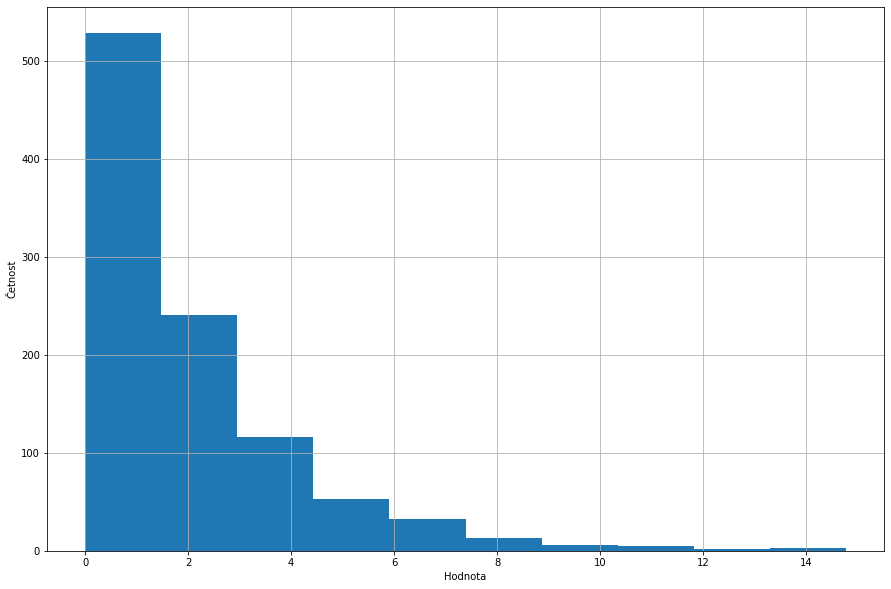

In [16]:
lam = 0.5
data = exponential(1 / lam, 1000)
plt.hist(data)
plt.grid('both')
plt.xlabel('Hodnota')
plt.ylabel('Četnost');

### Časová posloupnost / vznik požadavků

Pokud kumulativně sčítáme generované hodnoty, dostáváme okamžiky příchodů. Níže je zobrazena časová synchronizace dvou různých zdrojů.

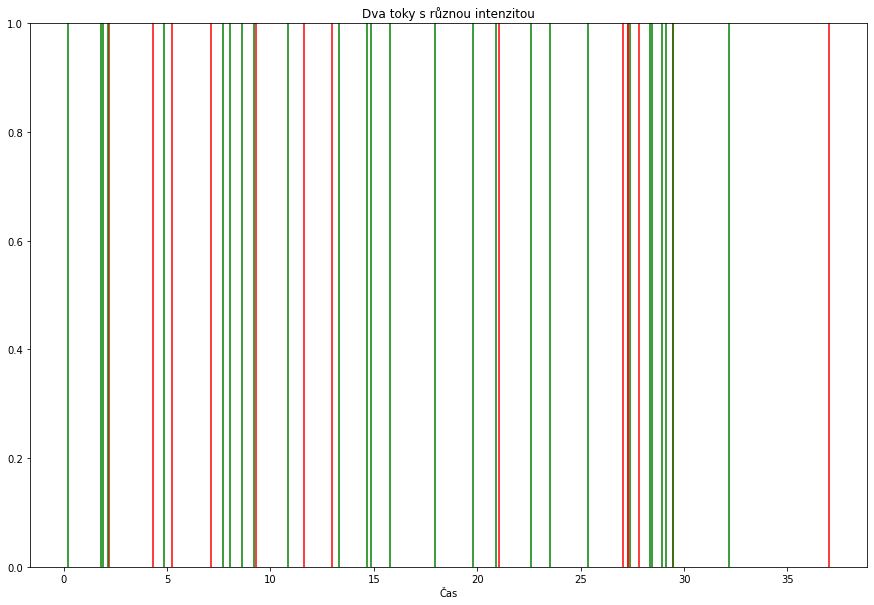

In [17]:
def plotFlow(maxTime, lam, color):
  currentTime = 0
  while currentTime < maxTime:
    currentTime = currentTime + rndEx(random, lam)
    plt.axvline(x = currentTime, color =color)

plotFlow(30, 0.5, color='red')    
plotFlow(30, 1, color='green')    
plt.title('Dva toky s různou intenzitou')
plt.xlabel('Čas');

In [18]:
def generateSequenceX(maxTime, lam):
  result = []
  currentTime = 0
  while currentTime < maxTime:
    currentTime = currentTime + rndEx(random, lam)
    result.append(currentTime)
  return result

## Událostní kalendář pro událostní simulaci

Třída pro událostní simulaci. Událostní simulace umožňuje spouštění událostí - akcí v časové souslednosti bez ohledu na souslednost plánování. 

Akce jsou v tomto případě popsány funkcemi, které jsou v simulaci volány s předpřipravenými parametry. 

In [19]:
class EventCalendar:
  def __init__(self):
    self._queue = []
    pass

  #Metoda pro vykonání jednoho kroku simulace
  def Step(self):
    #z fronty odstraň nejstarší událost
    currentEvent = self._queue.pop(0)

    #vyvolej funkci, která je spojena s danou událostí
    func = currentEvent['executor']
    time = currentEvent['time']
    result = func(time, **currentEvent['kwargs'])
    
    currentEvent['result'] = result
    #vrať událost, která byla zpracována
    return currentEvent

  #Metoda pro získání informace o času nejstarší události, 
  #tj. události, která bude zpracována jako první
  def PrepareNext(self):
    #vrať čas nejstarší události
    return self._queue[0]['time']

  #Vložení události do fronty událostí, 
  #futureTime - čas, kdy bude událost vyvolána
  #f - funkce, která bude v čase události vykonána / volána
  def AddEvent(self, futureTime, f, **kwargs):
    self._queue.append({'time': futureTime, 'executor': f, 'kwargs': kwargs})
    #setřídit frontu / list událostí podle položky time / čas
    self._queue.sort(key = lambda item: item['time'])
    return self

  def __iter__(self):  # we can return self here, because __next__ is implemented
      return self

  def __next__(self):
    return self.Step()


### Použití událostní simulace

Níže je definována funkce ```eventPrinter```, která vytiskne informaci o stavu simulace a naplánuje další událost.

In [20]:
def eventPrinter(time, calendar, value):
  print(f'At time\t{time}\tvalue is\t{value}')
  calendar.AddEvent(time + random(), eventPrinter, calendar = calendar, value = value + 1)

Na základě třídy ```EventCalendar``` je v náhodných čase volána funkce ```eventPrinter```. Tato funkce vytiskne informaci o stavu simulace a naplánuje další událost.

In [21]:
calendar = EventCalendar()
calendar.AddEvent(0, eventPrinter, calendar = calendar, value = 0)

for event in calendar:
  print(f"> At {event['time']} I have served an event")
  if event['time'] > 3:
    break

At time	0	value is	0
> At 0 I have served an event
At time	0.5168962828824223	value is	1
> At 0.5168962828824223 I have served an event
At time	0.7503340861235904	value is	2
> At 0.7503340861235904 I have served an event
At time	0.9170908978764418	value is	3
> At 0.9170908978764418 I have served an event
At time	1.5768471341162922	value is	4
> At 1.5768471341162922 I have served an event
At time	2.5611763245516004	value is	5
> At 2.5611763245516004 I have served an event
At time	2.7942677650964756	value is	6
> At 2.7942677650964756 I have served an event
At time	2.9166916661370763	value is	7
> At 2.9166916661370763 I have served an event
At time	3.269647344810335	value is	8
> At 3.269647344810335 I have served an event


## Simulace SHO M/M/1

In [22]:
λ = 1
µ = 2

### Příchod požadavku

Ve chvíli, kdy požadavek vstupuje do systému, je tento zařazen do fronty, je naplánován příchod dalšího požadavku a je realizován pokus o zahájení obsluhy požadavku.

In [23]:
queue = []
def customerArrived(time, calendar):

  # zařazení požadavku do fronty
  newCustomer = {'enterTime': time}
  queue.append(newCustomer)

  # naplánování dalšího příchodu
  deltaTime = exponential(1 / λ, 1)[0] # čas 
  calendar.AddEvent(time + deltaTime, customerArrived, calendar=calendar)

  # pokus o zahájení obsluhy
  calendar.AddEvent(time, tryBeginService, calendar=calendar)

### Obsluha požadavku

Pokus o zahájení obsluhy znamená, že pokud je systém obsluhy volný a fronta není prázdná, je zahájena obsluha. Součástí je také naplánování konce obsluhy.

In [24]:
servicePlace = {'inService': None}

def tryBeginService(time, calendar):
  if servicePlace['inService'] is None:
    if len(queue) > 0:
      customer = queue.pop()
      timeOfEnd = exponential(1 / µ, 1)[0] #jeden čas
      customer['beginService'] = time
      customer['endService'] = time + timeOfEnd
      servicePlace['inService'] = customer

      # Naplánování konce obsluhy
      calendar.AddEvent(time + timeOfEnd, endService, calendar=calendar)

Konec obsluhy uvolní obsluhu a pokusí se o zahájení obsluhy.

In [25]:
def endService(time, calendar):
  finishedCustomer = servicePlace['inService']
  servicePlace['inService'] = None
  calendar.AddEvent(time, tryBeginService, calendar=calendar)
  return finishedCustomer

### Sběr statistických ukazatelů

Nezbytnou součástí simulace je sběr statistických ukazatelů. Ty mohou být principiálně dvojího typu:
- číslo (např. délka fronty)
- logická hodnota (např. zda je obsluha volná)

V případě logických hodnot se tyto převádí na hodnoty 0 a 1. Interpretace statistických ukazatelů je poté jako pravděpodobnost, že výrok spojený s logickou hodnotou je pravdivý. Např. pravděpodobnost, že obsluha je volná.

Ke každému statistickému údaji potřebujeme dvě operace:
- zápis (sběr ukazatele a kumulace hodnot)
- čtení hodnoty ukazatele

Pro výpočet hodnoty statistického ukazetele se využívá průměrné hodnoty funkce v daném časovém intervalu.

$$\overline f = \frac{\int_{t_a}^{t_b}f(t)dt}{t_b-t_a}$$

diskrétní tvar této rovnice je

$$\overline f = \frac{\sum_{i=0}^n f(x) \Delta t_i}{\sum_{i=0}^n \Delta t_i}$$

dá se tedy tvrdit, že

$$ f_i^* = f_{i-1}^* + f(t) \Delta t_i$$

spolu s 

$$t_i^* = t_{i-1}^* + \Delta t_i$$

umožňuje spočítat

$$\overline f = \frac{f_i^*}{t_i^*}$$




Při simulaci je nezbytné si uvědomit:
- libovolný ukazatel se může změnit v libovolném kroku simulace a tedy je nutné v každém kroku simulace sledovat všechny parametry
- je nutné si před následujícím krokem simulace (neboli na konci kroku simulace) uložit hodnotu parametru $f(t)$ a na po realizaci kroku o délce $\Delta t_i$ kumulovat součin do pomocné proměnné $f_i^* = f_{i-1}^* +f(t) \Delta t_i$.

#### Délka fronty

In [26]:
queueStatistic = {'cumulativeValue': 0, 'value': 0, 'time': 0}
def checkQueueLength(time):
  deltaTime = time - queueStatistic['time']
  queueStatistic['time'] = time
  queueStatistic['cumulativeValue'] += deltaTime * queueStatistic['value']
  queueStatistic['value'] = len(queue) 

def getAvgLength():
  if queueStatistic['time'] > 0:
    return queueStatistic['cumulativeValue'] / queueStatistic['time']
  else:
    return 0

#### Obsluha je volná

In [27]:
serviceFull = {'cumulativeValue': 0, 'value': 0, 'time': 0}
def checkServiceFull(time):
  deltaTime = time - serviceFull['time']
  serviceFull['time'] = time
  serviceFull['cumulativeValue'] += deltaTime * serviceFull['value']
  serviceFull['value'] = 0
  if servicePlace['inService'] is None:
    serviceFull['value'] = 1

def getServiceAvailableProbability():
  if serviceFull['time'] > 0:  
    return serviceFull['cumulativeValue'] / serviceFull['time']    
  else:
    return 0

#### Obecný tvar pro libovolnou statistiku

Jak bylo výše uvedeno, ke každému statistickému údaji potřebujeme dvě operace:
- zápis (sběr ukazatele a kumulace hodnot)
- čtení hodnoty ukazatele

Níže je uvedena obecná implementace, která tuto potřebu uspokojí. Funkce ```createStatistic``` vrací dvě funkce, které slouží ke sběru údajů a k výpočtu průměrné hodnoty. Parametr ```valueGetter``` je funkce, která vrací aktuální hodnotu sledovaného parametru.

In [28]:
def createStatistic(valueGetter):
  data = {'cumulativeValue': 0, 'value': 0, 'time': 0}
  def collectData(time):
    deltaTime = time - data['time']
    data['time'] = time
    data['cumulativeValue'] += deltaTime * data['value']
    data['value'] = valueGetter()

  def getValue():
    if data['time'] > 0:  
      return data['cumulativeValue'] / data['time']    
    else:
      return 0  
  return collectData, getValue

Jako příklad lze uvést statistiku, která sleduje, zda délka fronty je větší než 5.

In [29]:
def decideIfLengthGT5():
  if len(queue) > 5:
    return 1
  else:
    return 0

updateLengthGT5, getLengthGT5 = createStatistic(decideIfLengthGT5)

Pro pokročilé je zde funkce ```appendStatistic```, která umožňuje statistické operace sjednotit do jedinné funkce.

In [31]:
def appendStatistic(prev=None, getter=None, name=None):
  localUpdate, localGet = createStatistic(getter)

  def innerCollectData(time):
    if not prev[0] is None:
      prev(time)
    localUpdate(time)

  def innerGetResult():
    if prev is None:
      result = {}
    else:
      result = prev[1]
    result[name] = localGet()
    return result
  return innerCollectData, innerGetResult

### Běh simulace

In [32]:
calendar = EventCalendar()

times = []
lengths = []
probability = []

calendar.AddEvent(0, customerArrived, calendar=calendar)
for event in calendar:
  #print(event)
  currentTime = event['time']
  checkQueueLength(currentTime)
  checkServiceFull(currentTime)

  times.append(currentTime)
  lengths.append(getAvgLength())
  probability.append(getServiceAvailableProbability())

  finishedCustomer = event['result']
  if not finishedCustomer is None:
    pass
  if event['time'] > 10000:
    break

S využitím poročilé statistiky to může vypadat takto

In [33]:
calendar = EventCalendar()

times = []
lengths = []
probability = []

wholeStatistic = appendStatistic(
    getter=lambda: len(queue), 
    name='queueLength')
wholeStatistic = appendStatistic(
    wholeStatistic, 
    getter=lambda: servicePlace['inService'] is None,
    name='serviceIsAvailable')

In [38]:
calendar.AddEvent(0, customerArrived, calendar=calendar)

checkStatistic, getStatistic = *wholeStatistic
print(wholeStatistic)
for event in calendar:
  #print(event)
  currentTime = event['time']
  checkStatistic(currentTime)

  if event['time'] > 10000:
    break

print(getStatistic())

SyntaxError: ignored

### Výsledek simulace

#### Textový výstup

In [ ]:
print(f'Průměrná délka fronty je {getAvgLength()}')
print(f'Pravděpodobnost, že obsluha bude volná {getServiceAvailableProbability()}')

Průměrná délka fronty je 0.4597000367351561
Pravděpodobnost, že obsluha bude volná 0.5075072669019897


#### Délka fronty

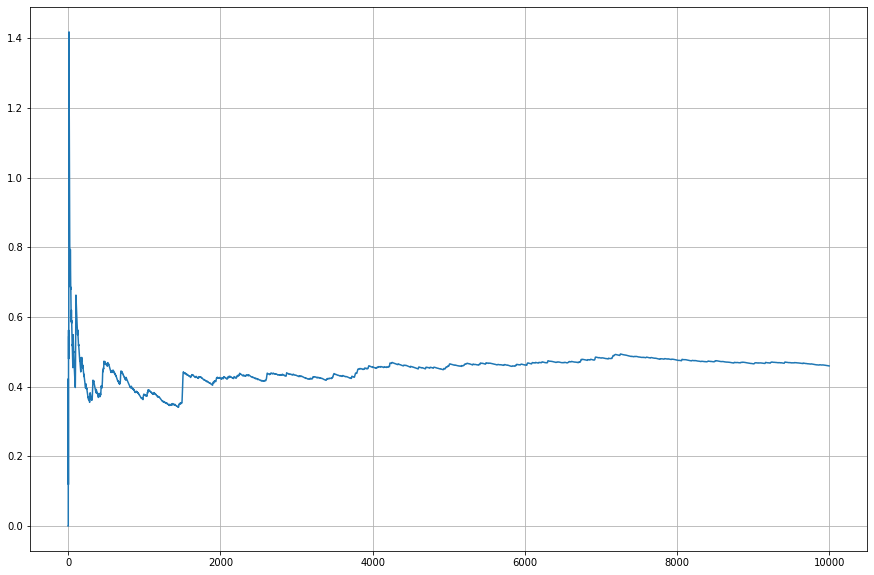

In [ ]:
plt.plot(times, lengths)
plt.grid()

#### Pravděpodobnost obsluha je volná

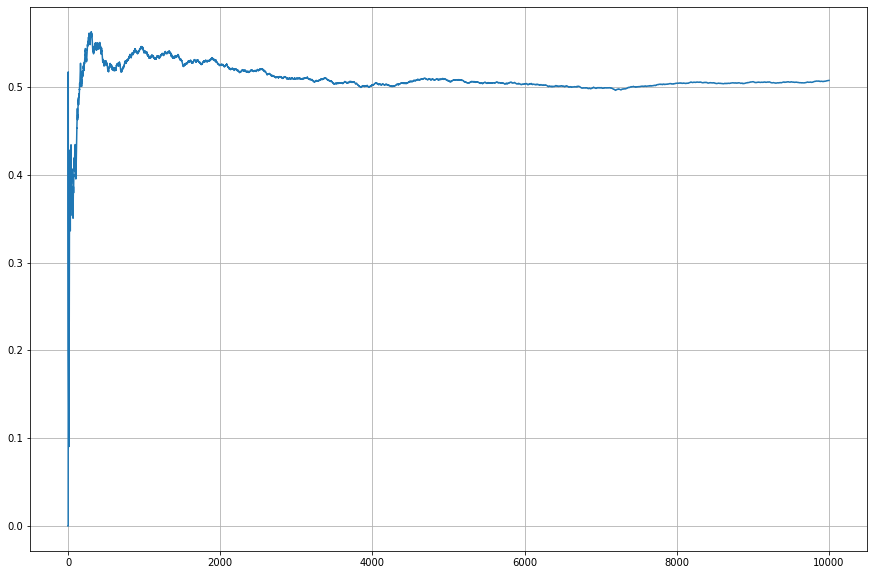

In [ ]:
plt.plot(times, probability)
plt.grid()

## Simulace SHO M/M/n

In [ ]:
λ = 4
µ = 2
n = 3

### Příchod požadavku

In [ ]:
queue = []
def customerArrived(time, calendar):
  deltaTime = exponential(1 / λ, 1)[0] #jeden čas
  calendar.AddEvent(time + deltaTime, customerArrived, calendar=calendar)
  calendar.AddEvent(time, tryBeginService, calendar=calendar)
  newCustomer = {'enterTime': time}
  queue.append(newCustomer)

### Obsluha požadavku

In [ ]:
servedRequests = []

def tryBeginService(time, calendar):
  if len(servedRequests) < n:
    if len(queue) > 0:
      customer = queue.pop()
      timeOfEnd = exponential(1 / µ, 1)[0] #jeden čas
      calendar.AddEvent(time + timeOfEnd, endService, calendar=calendar, customer=customer)
      customer['beginService'] = time
      customer['endService'] = time + timeOfEnd
      servedRequests.append(customer)

def endService(time, calendar, customer):
  servedRequests.remove(customer)
  calendar.AddEvent(time, tryBeginService, calendar=calendar)
  return customer

### Sběr statistických ukazatelů

#### Délka fronty

In [ ]:
def statQueueLength():
  return len(queue)

updateStatQueueLength, getStatQueueLength = createStatistic(statQueueLength)

#### Obsluha volná

In [ ]:
def statServiceFull():
  if len(servedRequests) >= n:
    return 1
  else:
    return 0

updateStatServiceFull, getStatServiceFull = createStatistic(statServiceFull)

### Běh simulace

In [ ]:
calendar = EventCalendar()

times = []
lengths = []
probability = []

calendar.AddEvent(0, customerArrived, calendar=calendar)
for event in calendar:
  currentTime = event['time']
  updateStatQueueLength(currentTime)
  updateStatServiceFull(currentTime)

  times.append(currentTime)
  lengths.append(getStatQueueLength())
  probability.append(getStatServiceFull())

  finishedCustomer = event['result']
  if not finishedCustomer is None:
    pass
  if event['time'] > 10000:
    break

### Výsledek simulace

#### Textový výstup

In [ ]:
print(f'Průměrná délka fronty je {getStatQueueLength()}')
print(f'Pravděpodobnost, že obsluha bude volná {getStatServiceFull()}')

Průměrná délka fronty je 0.8900550380444455
Pravděpodobnost, že obsluha bude volná 0.4407912160280959


#### Délka fronty

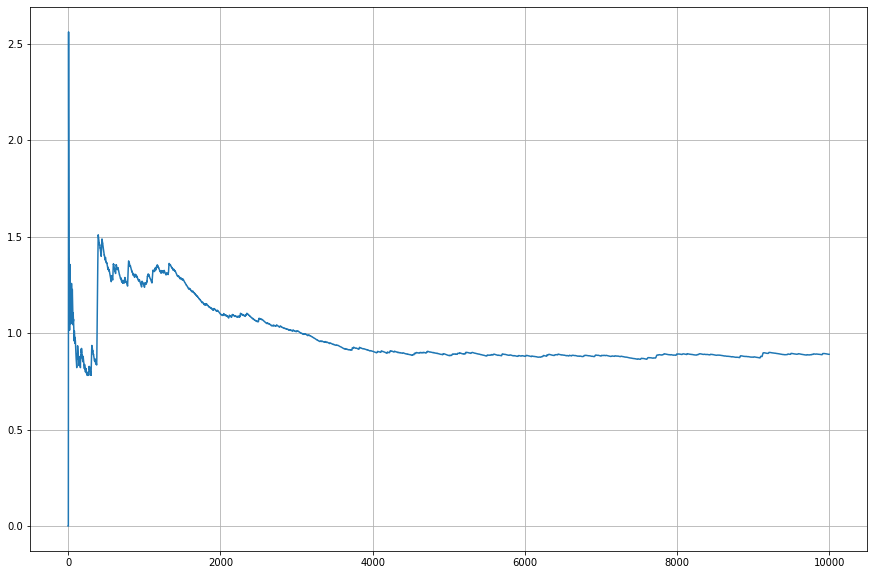

In [ ]:
plt.plot(times, lengths)
plt.grid()

#### Pravděpodobnost obsluha je volná

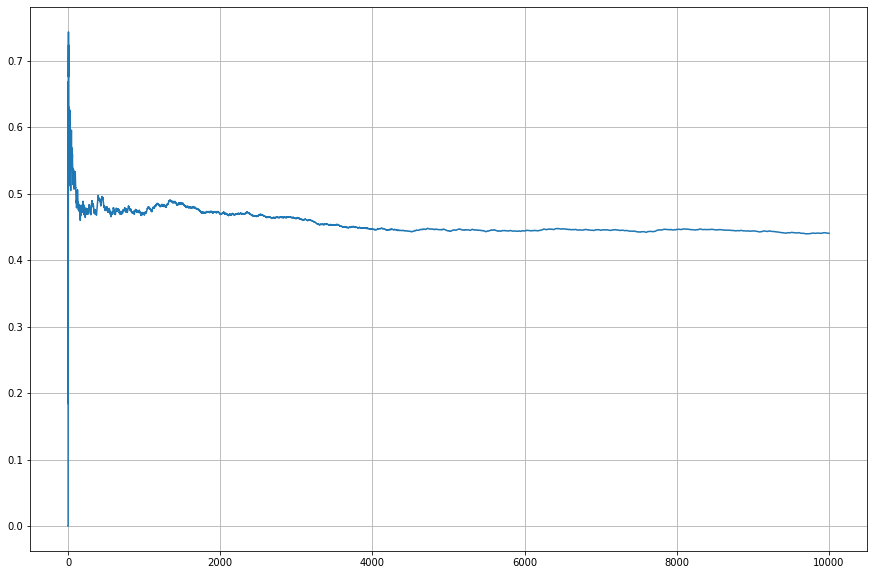

In [ ]:
plt.plot(times, probability)
plt.grid()